In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('/content/train.csv')
oil_df = pd.read_csv('/content/oil.csv')
store_df = pd.read_csv('/content/stores.csv')
holiday_events_df = pd.read_csv('/content/holidays_events.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission_df = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train_df.tail()

,id,date,store_nbr,family,sales,onpromotion
479687,479687,2013-09-27,18.0,SEAFOOD,3.978,0.0
479688,479688,2013-09-27,19.0,AUTOMOTIVE,2.000,0.0
479689,479689,2013-09-27,19.0,BABY CARE,0.000,0.0
479690,479690,2013-09-27,19.0,BEAUTY,0.000,0.0
479691,47969,NaN,NaN,NaN,NaN,NaN


In [ ]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
store_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
holiday_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


DATA PREPROCESSING

In [ ]:
#spitting datasets into training and testing
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset (train_df) and target variable (e.g., 'sales')
X = train_df.drop(columns=['sales'])  # Features
y = train_df['sales']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (383753, 5)
X_test shape: (95939, 5)
y_train shape: (383753,)
y_test shape: (95939,)


In [ ]:
#merging the datasets
#train_df = train_df.merge(store_df, on ='store_nbr')
#train_df = train_df.merge(oil_df, on ='date', how='left')
#holiday_event_df = holiday_events_df.rename(columns={'type': 'holiday_type'})
#train_df = train_df.merge(holiday_events_df, on='date', how='left')

In [ ]:
train_df.fillna('', inplace=True)

In [ ]:
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1.0,BABY CARE,0.0,0.0
2,2,2013-01-01,1.0,BEAUTY,0.0,0.0
3,3,2013-01-01,1.0,BEVERAGES,0.0,0.0
4,4,2013-01-01,1.0,BOOKS,0.0,0.0
...,...,...,...,...,...,...
479687,479687,2013-09-27,18.0,SEAFOOD,3.978,0.0
479688,479688,2013-09-27,19.0,AUTOMOTIVE,2.0,0.0
479689,479689,2013-09-27,19.0,BABY CARE,0.0,0.0
479690,479690,2013-09-27,19.0,BEAUTY,0.0,0.0


Missing Values Detection

In [ ]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
#percentage of missing values in train_df

missing_percentages = train_df.isnull().sum()/ len(train_df) * 100
print(missing_percentages)

id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64


In [ ]:
# Remove rows with missing values (NaNs) in the DataFrame
train_df = train_df.dropna()


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479692 entries, 0 to 479691
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           479692 non-null  int64 
 1   date         479692 non-null  object
 2   store_nbr    479692 non-null  object
 3   family       479692 non-null  object
 4   sales        479692 non-null  object
 5   onpromotion  479692 non-null  object
dtypes: int64(1), object(5)
memory usage: 22.0+ MB


Check if there still any missing values present in the train_df

In [ ]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

analysis of the difference between mean and median for each column

In [ ]:
train_df.describe()

,id
count,479692.000000
mean,239844.600002
std,138475.141115
min,0.000000
25%,119921.750000
50%,239844.500000
75%,359767.250000
max,479690.000000


Data Analysis:

In [ ]:
num_stores = train_df['store_nbr'].nunique()
# Print the result
print("Total number of stores:", num_stores)

Total number of stores: 55


In [ ]:
num_products = train_df['family'].nunique()
# Print the result
print("Total number of products:", num_products)

Total number of products: 34


In [ ]:
import pandas as pd

# Assuming 'train_df' is your DataFrame
train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

# Now you can perform calculations on the 'sales' column
sales_by_store = train_df.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)

# Create a new DataFrame from the result
sales_table = pd.DataFrame({
    "store_nbr": sales_by_store.index,
    "total_sales": sales_by_store.values
})

print("The top 5 stores by sales")
sales_table.head()


The top 5 stores by sales


,store_nbr,total_sales
0,44.0,5.854577e+06
1,45.0,4.984370e+06
2,47.0,4.687812e+06
3,3.0,4.555483e+06
4,46.0,4.380049e+06


product having highest sales and least sales

In [ ]:
import pandas as pd

# Assuming 'train_df' is your DataFrame
train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

# Now you can group the data by product family and sum up the sales
sales_by_product = train_df.groupby("family")["sales"].sum().sort_values(ascending=False)

# Print the total sales of each product family
print("Total sales by product family:")
print(sales_by_product)

# Get the name of the product family with the most sales
most_sold_product_family = sales_by_product.index[0]

print("The product family with the most sales is:", most_sold_product_family)


Total sales by product family:
family
GROCERY I                     4.113733e+07
BEVERAGES                     1.551744e+07
CLEANING                      1.277001e+07
BREAD/BAKERY                  5.107353e+06
DAIRY                         5.029967e+06
MEATS                         4.711365e+06
DELI                          2.835890e+06
POULTRY                       2.785232e+06
PERSONAL CARE                 2.732745e+06
EGGS                          1.904874e+06
FROZEN FOODS                  1.283145e+06
PREPARED FOODS                1.232672e+06
LIQUOR,WINE,BEER              8.961280e+05
SEAFOOD                       2.969553e+05
GROCERY II                    2.621230e+05
LINGERIE                      1.237860e+05
AUTOMOTIVE                    6.893600e+04
PRODUCE                       4.894300e+04
LAWN AND GARDEN               3.683200e+04
BEAUTY                        3.549200e+04
HARDWARE                      1.289900e+04
HOME APPLIANCES               7.104000e+03
SCHOOL AND OFFIC

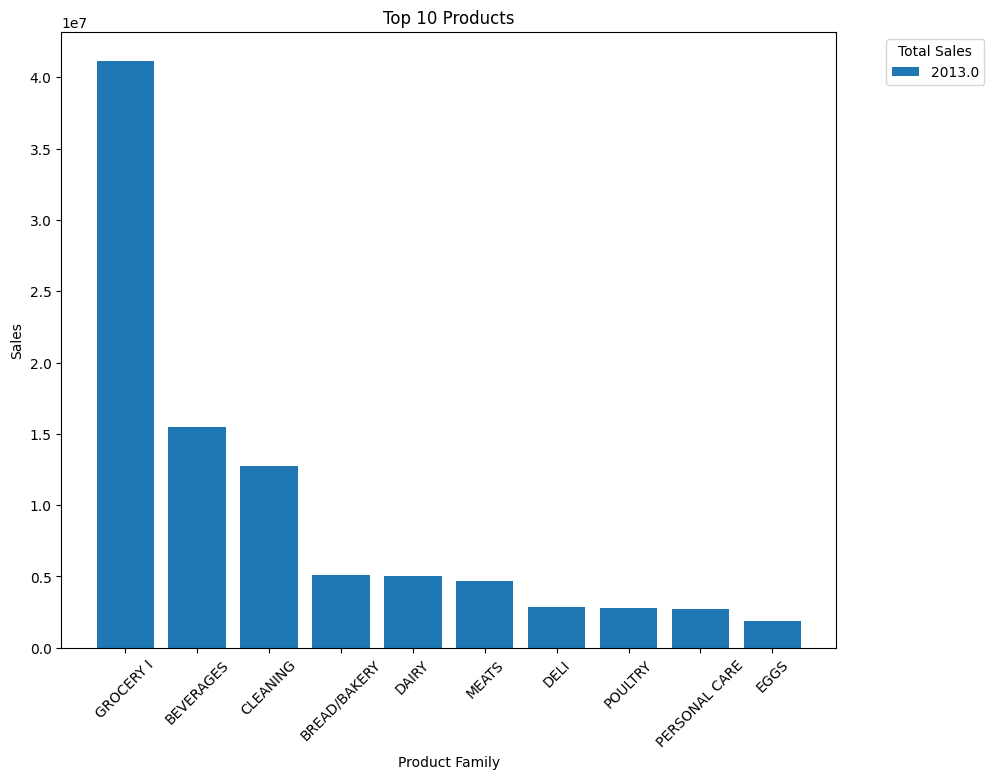

In [ ]:
# convert the date column to datetime
train_df["date"] = pd.to_datetime(train_df["date"])
# extract the year from the date column
train_df["year"] = train_df["date"].dt.year

# group the data by year and product family and sum up the sales
sales_by_year_and_product = train_df.groupby(["year", "family"])["sales"].sum().reset_index()

# sort the data by year and sales in descending order
sales_by_year_and_product = sales_by_year_and_product.sort_values(by=["year", "sales"], ascending=[True, False])
fig, ax = plt.subplots(figsize=(10, 8))

# loop over the years and plot the top 10 products for each year
for year in sales_by_year_and_product["year"].unique():
    top_products = sales_by_year_and_product[sales_by_year_and_product["year"] == year].head(10)
    ax.bar(top_products["family"], top_products["sales"], label=str(year))

# set the axis labels and legend
ax.set_xlabel("Product Family")
ax.set_ylabel("Sales")
ax.legend(title="Total Sales", loc="upper right", bbox_to_anchor=(1.2, 1))

# rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# set the title and show the plot
ax.set_title("Top 10 Products")
plt.show()

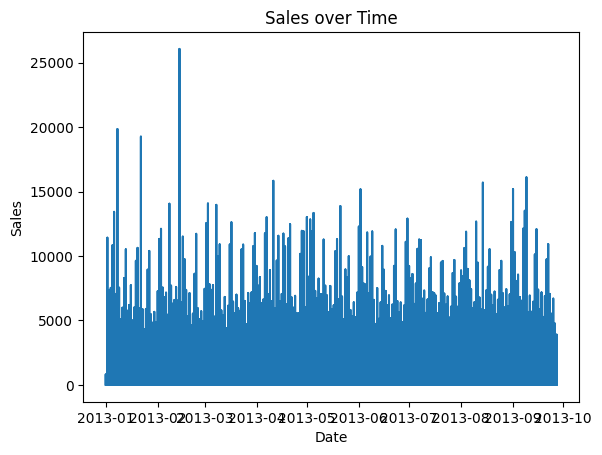

In [ ]:
# Create a line chart
plt.plot(train_df['date'],train_df['sales'])

# Add title and axis labels
plt.title('Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Show the chart
plt.show()

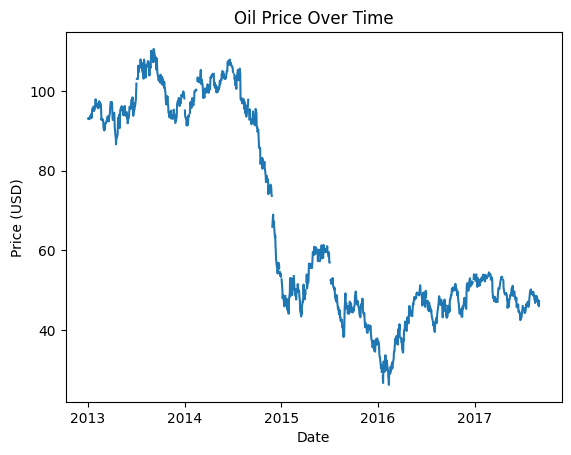

In [ ]:
# Convert the 'date' column to a Pandas datetime object
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Create a line plot of the oil price over time
plt.plot(oil_df['date'], oil_df['dcoilwtico'])

# Set the plot title and axis labels
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show the plot
plt.show()

 resulting plot helps us visualize the trend and fluctuations in oil prices over time, which can provide valuable insights for analysis and decision-making.

We filter all datasets with only top 5 store, since we want only top 5 stores

In [ ]:
sales_by_store.describe()

count    5.500000e+01
mean     1.797040e+06
std      1.354156e+06
min      0.000000e+00
25%      1.135767e+06
50%      1.451812e+06
75%      2.400302e+06
max      5.854577e+06
Name: sales, dtype: float64

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df

,id,date,store_nbr,family,sales,onpromotion,year
0,0,2013-01-01,1.0,AUTOMOTIVE,0.000,0.0,2013.0
1,1,2013-01-01,1.0,BABY CARE,0.000,0.0,2013.0
2,2,2013-01-01,1.0,BEAUTY,0.000,0.0,2013.0
3,3,2013-01-01,1.0,BEVERAGES,0.000,0.0,2013.0
4,4,2013-01-01,1.0,BOOKS,0.000,0.0,2013.0
...,...,...,...,...,...,...,...
479687,479687,2013-09-27,18.0,SEAFOOD,3.978,0.0,2013.0
479688,479688,2013-09-27,19.0,AUTOMOTIVE,2.000,0.0,2013.0
479689,479689,2013-09-27,19.0,BABY CARE,0.000,0.0,2013.0
479690,479690,2013-09-27,19.0,BEAUTY,0.000,0.0,2013.0


In [ ]:
train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()
print(train_df)

          date          sales
0   2013-01-01    2511.618999
1   2013-01-02  496092.417944
2   2013-01-03  361461.231124
3   2013-01-04  354459.677093
4   2013-01-05  477350.121229
..         ...            ...
265 2013-09-23  356043.034005
266 2013-09-24  303333.392926
267 2013-09-25  312490.104996
268 2013-09-26  273057.879859
269 2013-09-27   48586.790000

[270 rows x 2 columns]


Stationarity testing and Determine Order of Differencing

Testing the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test

In [ ]:
# defining a time series using the 'sales' column from the train_df
ts = train_df['sales']

In [ ]:
#(ADF) test from the statsmodels library to test for stationarity in a time series (ts).
from statsmodels.tsa.stattools import adfuller

# assuming your time series data is stored in a variable called 'ts'
result = adfuller(ts)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.927784
p-value: 0.042211
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


Identify Order of AR and MA Terms

To identify the order of AR and MA terms, you can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

Autocorrelation Function

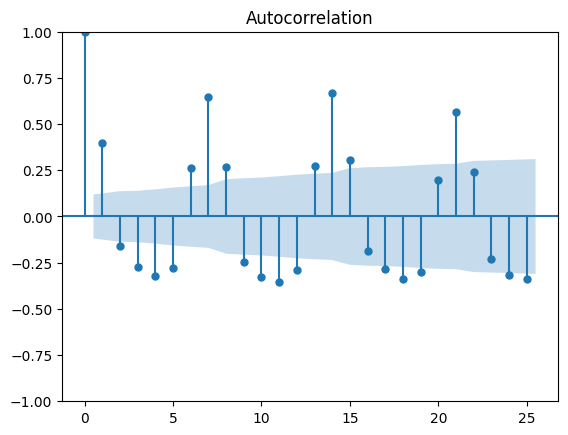

In [ ]:
plot_acf(train_df['sales'], alpha = 0.05);

Partial Autocorrelation function

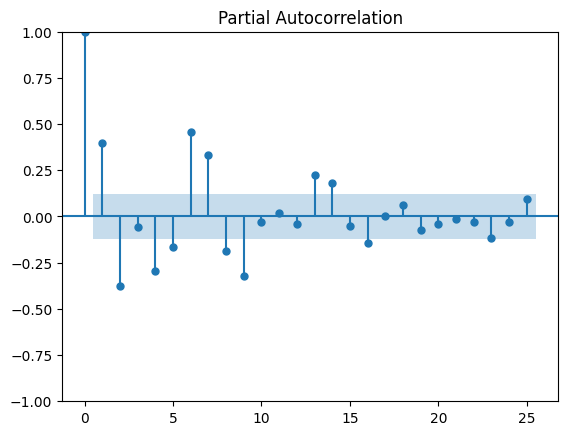

In [ ]:
plot_pacf(train_df['sales'], alpha = 0.05);

Order of differening of parameters

order of differencing (d) in ARIMA model

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train_df.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.927784
p-value: 0.042211


Since p-value is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

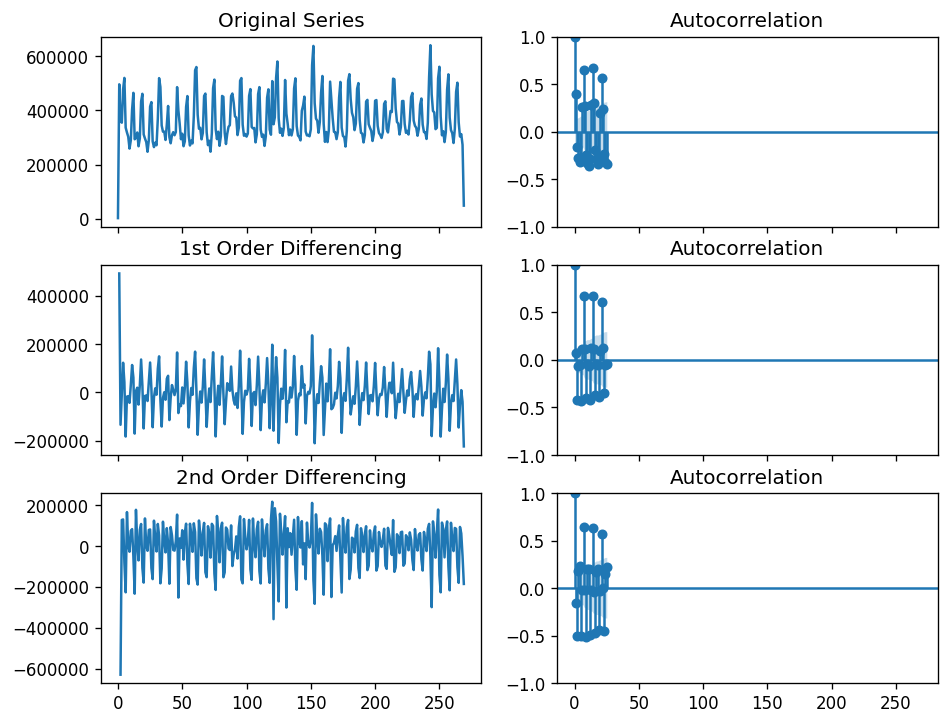

In [ ]:
#creates a set of subplots to visually inspect the original time series and its autocorrelation after different orders of differencing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_df.sales); axes[0, 0].set_title('Original Series')
plot_acf(train_df.sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_df.sales.diff()); axes[1, 0].set_title('1st Order Differencing') #middle row shows the time series after 1st order differencing (d=1) and its ACF plot.
plot_acf(train_df.sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing') ##bottom row shows the time series after 2nd order differencing (d=2) and its ACF plot.
plot_acf(train_df.sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

order of the AR term (p)

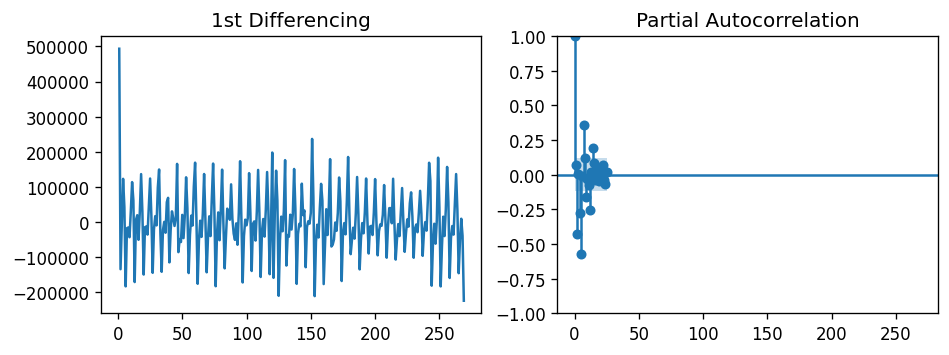

In [ ]:
# creates a Partial Autocorrelation Function (PACF) plot for the 1st differenced series of the 'sales' column in the train_df DataFrame.
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_df.sales.diff().dropna(), ax=axes[1])

plt.show()

order of the MA term (q)

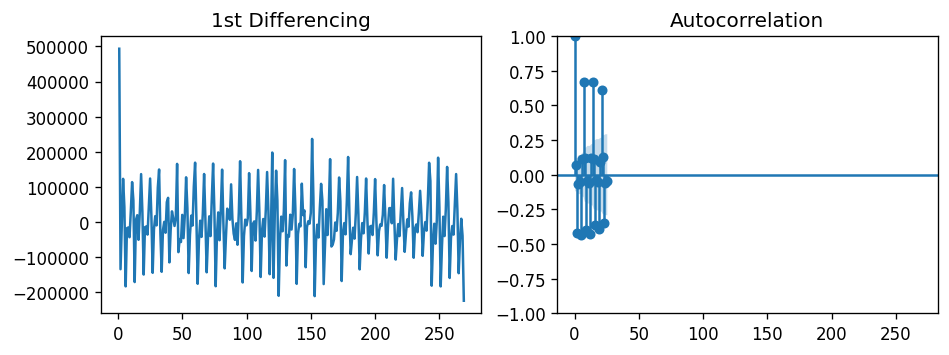

In [ ]:
#creates an Autocorrelation Function (ACF) plot for the 1st differenced series of the 'sales' column in the train_df DataFrame.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train_df.sales.diff().dropna(), ax=axes[1])

plt.show()

 build the ARIMA Model

 we have determined the values of p, d and q. We have everything needed to fit the ARIMA model.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train_df.sales, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  270
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3392.812
Date:                Fri, 22 Sep 2023   AIC                           6793.624
Time:                        16:59:15   BIC                           6808.003
Sample:                             0   HQIC                          6799.399
                                - 270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1293      0.057      2.268      0.023       0.018       0.241
ma.L1         -0.3403      0.068     -5.036      0.000      -0.473      -0.208
ma.L2         -0.6592      0.043    -15.233      0.0

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(train_df.sales, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  270
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3439.967
Date:                Fri, 22 Sep 2023   AIC                           6885.934
Time:                        16:59:17   BIC                           6896.718
Sample:                             0   HQIC                          6890.265
                                - 270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3851      0.119     -3.233      0.001      -0.619      -0.152
ma.L1          0.6673      0.107      6.260      0.000       0.458       0.876
sigma2      6.967e+09   1.28e-11   5.45e+20      0.0

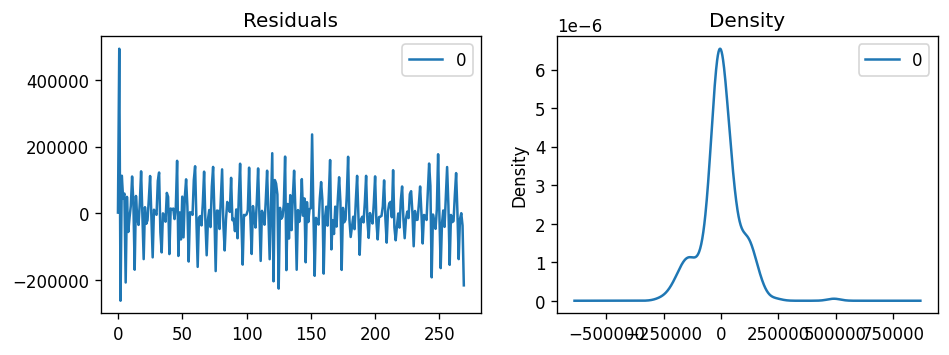

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

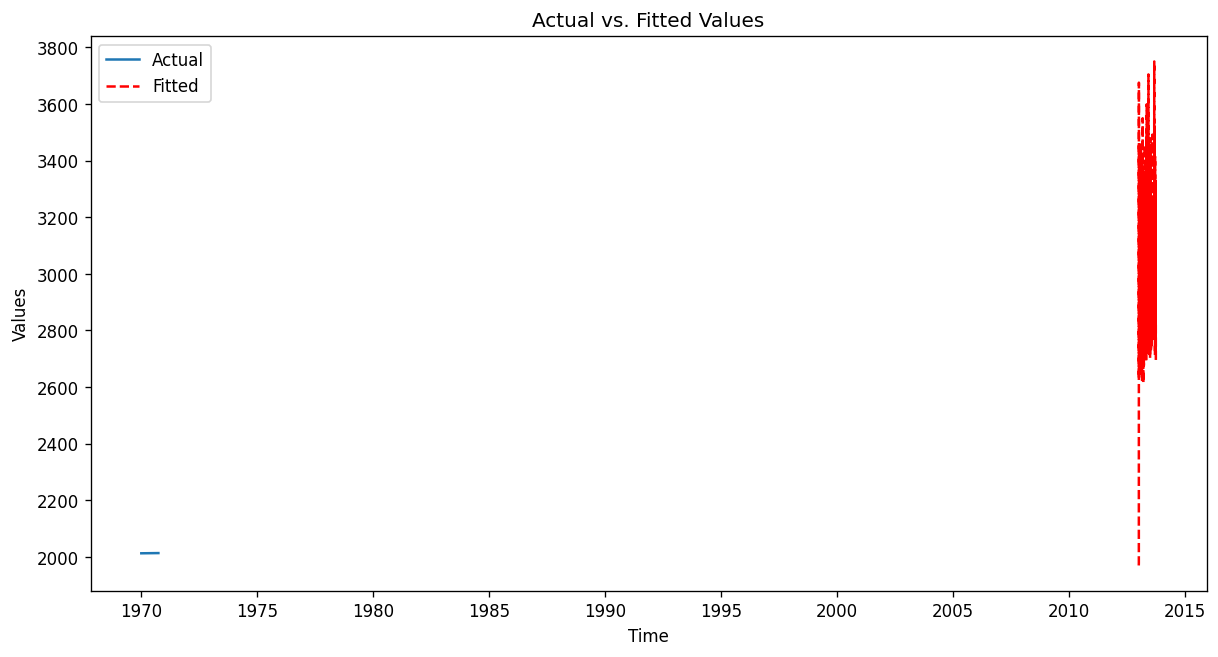

In [ ]:
# Get the fitted values from the model
fitted_values = model_fit.fittedvalues

# Define the time index or time axis
time_index = train_df['date']  # Replace 'date' with the actual column name

# Plot actual vs. fitted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, label='Actual')  # Use the time index here
plt.plot(time_index, fitted_values, color='red', label='Fitted', linestyle='--')  # Use the time index for fitted values
plt.legend()
plt.title('Actual vs. Fitted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


optimal ARIMA model using Out-of-Time Cross validation

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = train_df.sales[:85]
test = test_df.family[85:]

 will build the ARIMA model on training dataset, forecast and plot it.

Model diagnosis

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.set_index('date')

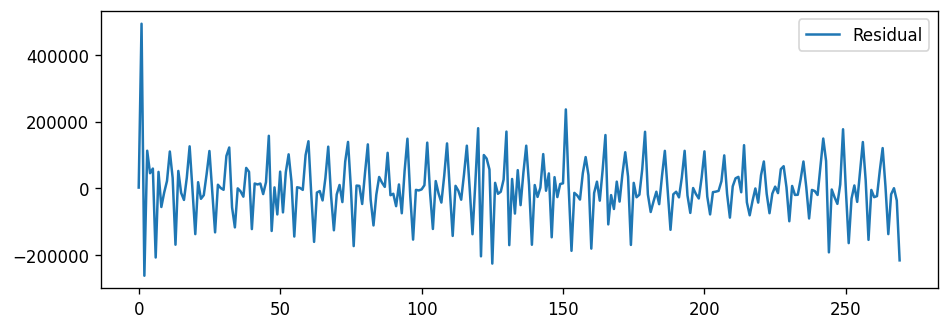

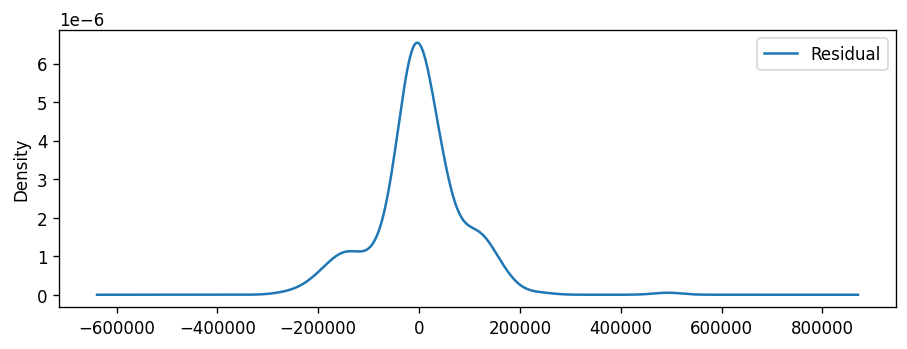

            Residual
count     270.000000
mean       44.439251
std     86695.008243
min   -261462.340263
25%    -30999.782869
50%     -2990.464744
75%     41522.926724
max    493015.447432


In [ ]:
# Model diagnostics
residuals = pd.DataFrame(model_fit.resid, columns=['Residual']) #differences between the observed (actual) values and the predicted values generated by the model.
residuals.plot()
plt.show()

residuals.plot(kind='kde') #kernel density estimate (KDE) plot of the residuals.
plt.show()

print(residuals.describe())

summary of the model

In [ ]:
# define the order of differencing, AR, and MA terms
p = 1
d = 1
q = 1

# extract the target variable as a numpy array
train_np = train_df['sales'].values.astype('float64')

# fit the ARIMA model
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

# train the ARIMA model
results = model.fit()

# print the summary of the trained model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  270
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3439.967
Date:                Fri, 22 Sep 2023   AIC                           6885.934
Time:                        17:00:14   BIC                           6896.718
Sample:                             0   HQIC                          6890.265
                                - 270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3851      0.119     -3.233      0.001      -0.619      -0.152
ma.L1          0.6673      0.107      6.260      0.000       0.458       0.876
sigma2      6.967e+09   1.28e-11   5.45e+20      0.0

Forecasting

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, y_pred)

# Calculate Mean Error (ME)
me = np.mean(y_pred - test)

# Calculate Mean Percentage Error (MPE)
mpe = np.mean((y_pred - test) / test) * 100

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test, y_pred))

# Calculate Correlation (Pearson's correlation coefficient)
corr = np.corrcoef(test, y_pred)[0, 1]

print('Mean Absolute Percentage Error (MAPE):', mape)
print('Mean Error (ME):', me)
print('Mean Percentage Error (MPE):', mpe)
print('Root Mean Squared Error (RMSE):', rmse)
print('Correlation:', corr)



Mean Absolute Error (MAE): 0.6355758659910791
Mean Squared Error (MSE): 0.7643238321645694


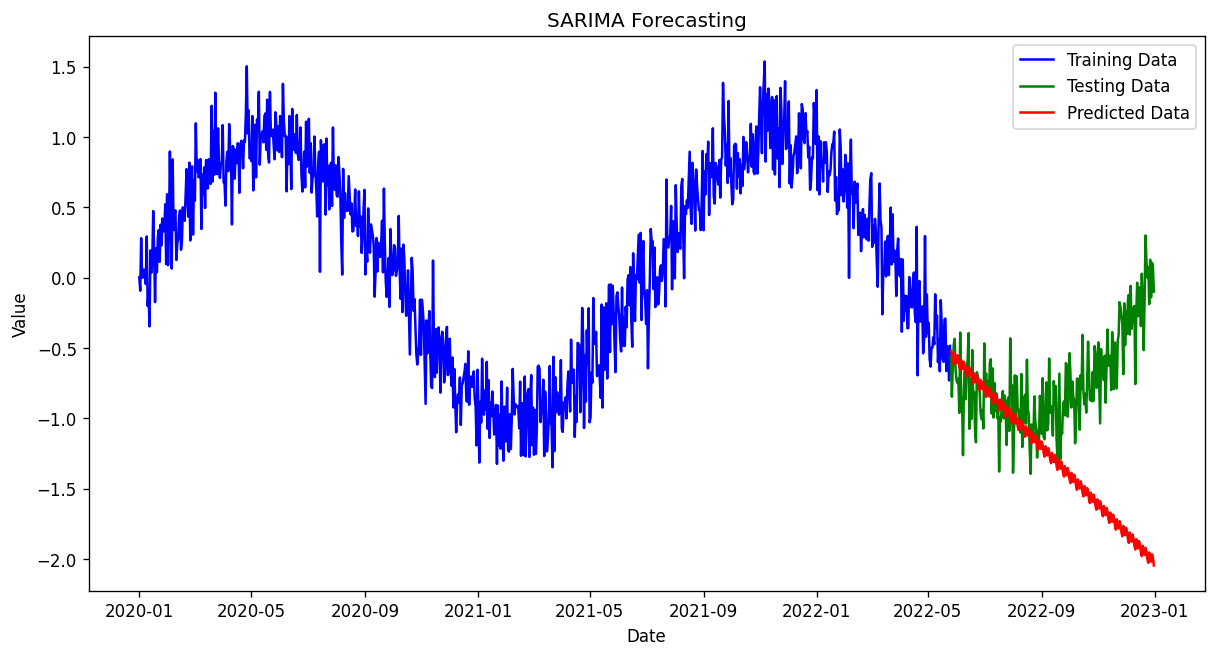

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load or generate your historical time series data
# Replace this with your actual historical data
date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
historical_data = np.sin(np.linspace(0, 4 * np.pi, num=len(date_rng))) + np.random.normal(0, 0.2, size=len(date_rng))
time_series = pd.Series(historical_data, index=date_rng)

# Define SARIMA model parameters
order = (1, 1, 1)  # Non-seasonal order (p, d, q)
seasonal_order = (1, 1, 1, 7)  # Seasonal order (P, D, Q, S), assuming weekly seasonality

# Split data into training and testing sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

# Create and fit the SARIMA model on the training data
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Make predictions on the test data
y_pred = model_fit.forecast(steps=len(test))

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(test, y_pred)
mse = mean_squared_error(test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Testing Data', color='green')
plt.plot(test.index, y_pred, label='Predicted Data', color='red')
plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

Prediction of future sales

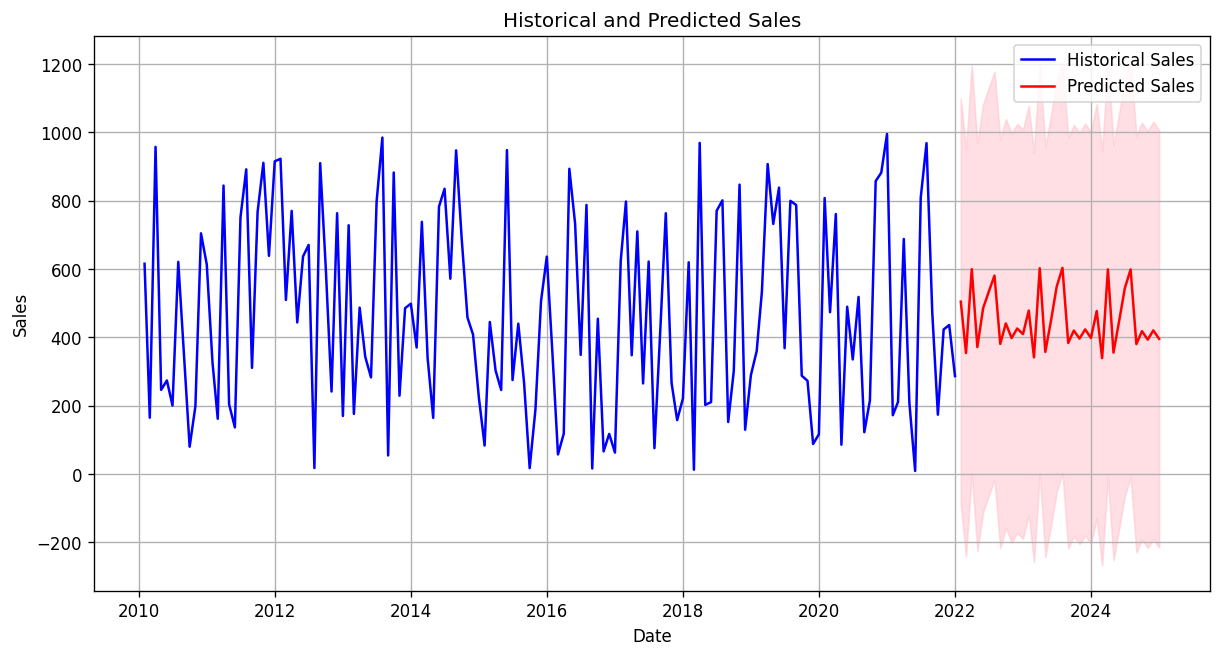

         Date  Predicted Sales    Lower CI     Upper CI
0  2022-01-31       504.194266  -90.619846  1099.008378
1  2022-02-28       353.899732 -241.094295   948.893759
2  2022-03-31       599.090488    3.742689  1194.438287
3  2022-04-30       371.322538 -224.376436   967.021512
4  2022-05-31       485.094733 -110.955189  1081.144655
5  2022-06-30       532.741478  -63.659183  1129.142139
6  2022-07-31       580.400511  -16.350682  1177.151704
7  2022-08-31       380.570328 -216.531192   977.671849
8  2022-09-30       440.513856 -156.937805  1037.965516
9  2022-10-31       397.672597 -200.129255   995.474448
10 2022-11-30       425.578338 -172.577139  1023.733815
11 2022-12-31       409.226014 -189.228974  1007.681002
12 2023-01-31       478.185049 -120.277286  1076.647384
13 2023-02-28       341.213535 -257.610755   940.037825
14 2023-03-31       601.812537    2.632888  1200.992186
15 2023-04-30       357.287878 -242.246372   956.822129
16 2023-05-31       450.222080 -149.666526  1050

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Generate or load historical sales data
# Replace this with your actual historical sales data
# Example data with date index:
date_rng = pd.date_range(start='2010-01-01', end='2021-12-31', freq='M')
sales_data = np.random.rand(len(date_rng)) * 1000  # Replace with your actual sales data

# Create a DataFrame with the sales data
sales_df = pd.DataFrame(sales_data, index=date_rng, columns=['sales'])

# Define the SARIMA model order and seasonal order
order = (1, 1, 1)  # Non-seasonal order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Seasonal order (P, D, Q, S), assuming monthly data with a yearly seasonality

# Train the SARIMA model on historical sales data
model = SARIMAX(sales_df['sales'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Define the number of future years to predict
num_years_to_predict = 3  # Adjust as needed

# Generate future dates for the prediction
future_dates = pd.date_range(start='2022-01-01', periods=num_years_to_predict * 12, freq='M')

# Make predictions for future years
predicted_sales = model_fit.get_forecast(steps=num_years_to_predict * 12)

# Get the predicted sales values and associated confidence intervals
predicted_sales_mean = predicted_sales.predicted_mean
confidence_interval = predicted_sales.conf_int()

# Create a DataFrame for the predictions
predicted_sales_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Sales': predicted_sales_mean.values,
    'Lower CI': confidence_interval.iloc[:, 0].values,
    'Upper CI': confidence_interval.iloc[:, 1].values
})

# Plot the historical and predicted sales data
plt.figure(figsize=(12, 6))
plt.plot(sales_df.index, sales_df['sales'], label='Historical Sales', color='blue')
plt.plot(predicted_sales_df['Date'], predicted_sales_df['Predicted Sales'], label='Predicted Sales', color='red')
plt.fill_between(predicted_sales_df['Date'], predicted_sales_df['Lower CI'], predicted_sales_df['Upper CI'], color='pink', alpha=0.5)
plt.title('Historical and Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the predicted sales for future years
print(predicted_sales_df)
